In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


C:\Users\katerina\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


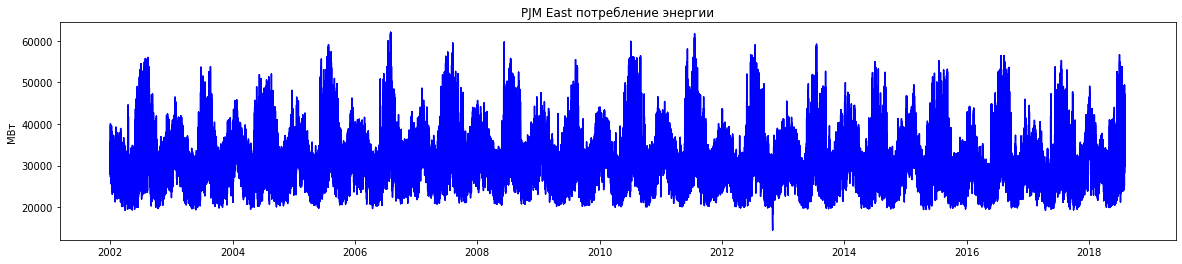

In [3]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

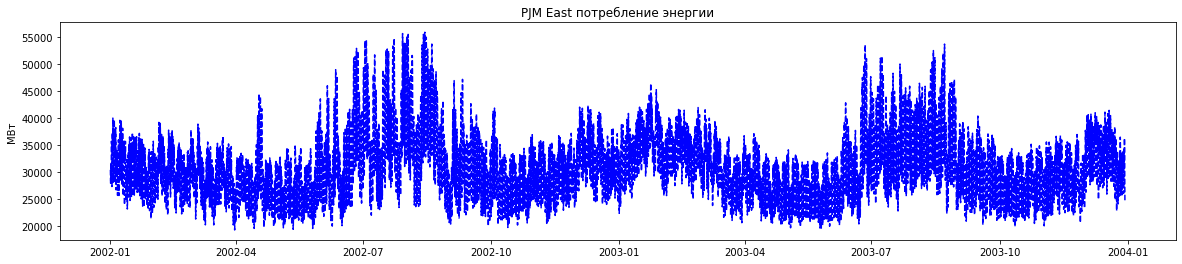

In [4]:
date_time =data['PJME_MW']
date_time.index = pd.date_range(data.index[0], periods=data.index.shape[0], freq="H")
plt.figure(figsize =(20,4))
plt.plot( date_time.index[:24*7*104], date_time.values[:24*7*104], '--b' )

plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [6]:
data_m = data.resample('M').mean()

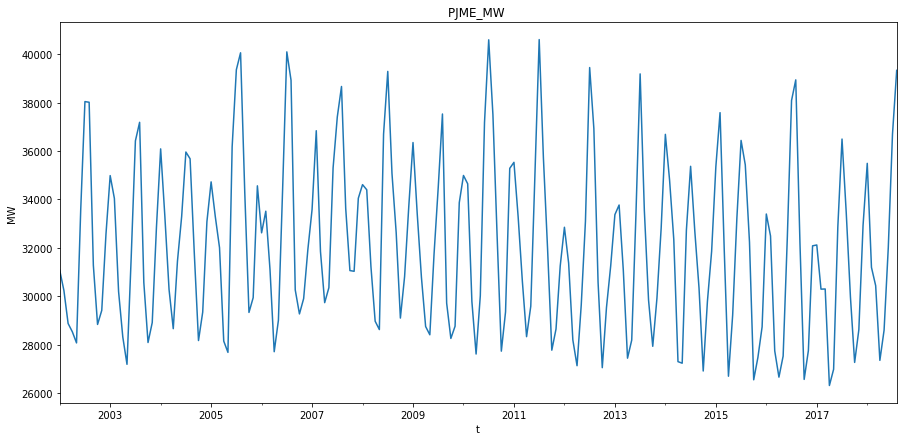

In [10]:
_ = data_m['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

In [11]:
data_y = data.resample('Y').mean()

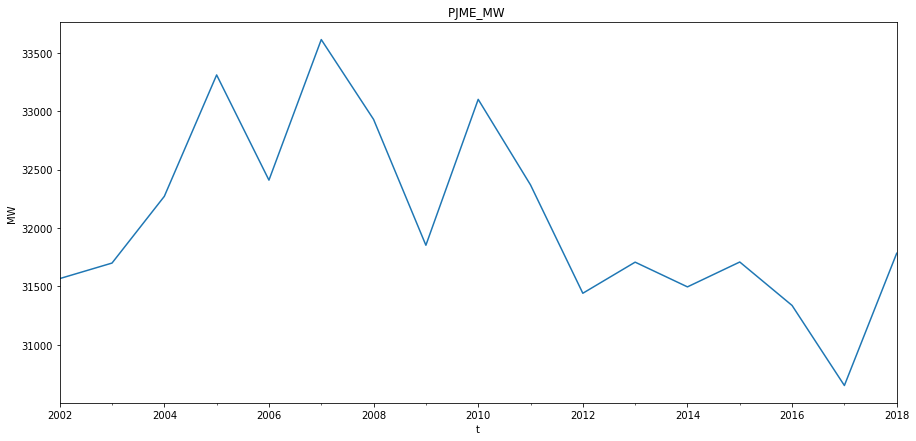

In [13]:
_ = data_y['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

In [14]:
d_data = data['PJME_MW'].values[1:]-data['PJME_MW'].values[:-1]

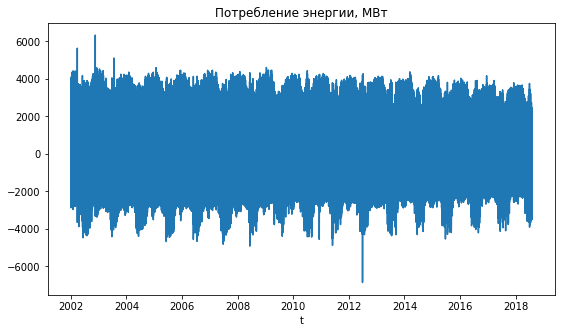

In [15]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(data.iloc[:-1].index,d_data)
plt.xlabel('t')
plt.title('Потребление энергии, МВт')
plt.show()

In [16]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [17]:
DF_data = sm.tsa.stattools.adfuller(data_m['PJME_MW'].values,regression='ctt')
DF_data

(-2.577455591729316,
 0.5247860093678429,
 15,
 184,
 {'1%': -4.435220952056536,
  '5%': -3.86487409876613,
  '10%': -3.5733156719443473},
 3230.9060995689206)

In [20]:
DF_data_d = sm.tsa.stattools.adfuller(d_data,regression='ctt')
print('коэффициент ADF для 1-й разности потребления энергии: ', DF_data_d[1])

коэффициент ADF для 1-й разности потребления энергии:  0.0


# Сглаживание

In [31]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [50]:
d_data=data.resample('D').mean()

Text(0.5, 1.0, 'PJME_MW')

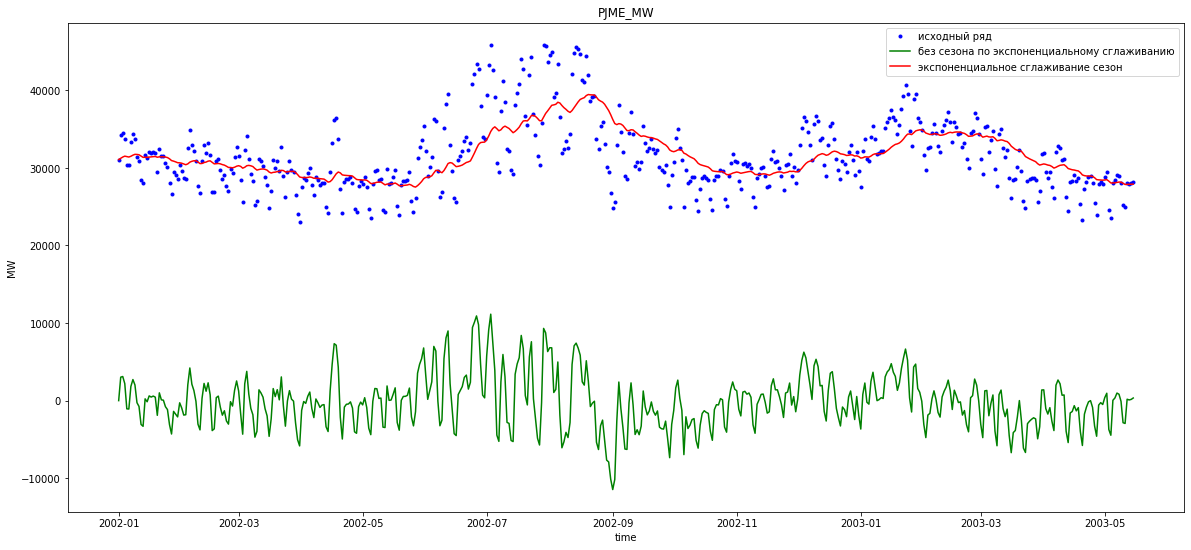

In [51]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW'], 0.05)

plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [52]:
df= pd.DataFrame(data_exp_1)
df.head()


,0
0,31080.739130
1,31239.779257
2,31403.384044
3,31518.987759
4,31463.294621


In [40]:
df.columns

Index([0, 't', 't1', 't2'], dtype='object')

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b( df, '10-10-2018')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

KeyError: 'Level Date must be same as name (None)'